# DC, IP, and SIP inversions in 2D

**Author**: Seogi Kang

This is a core notebook which illustrates Section 3.3 in Kang and Oldenburg (2019). 
There are four main items in this notebook:

1. DC inversion
2. Conventional IP inversion
3. Use 2 but sequentially apply for all time channels IP data to obtain pseudo-chargeabilties at multiple times
4. Extract SE parameters from the obtained pseudo-chargeabilties (conventional)
5. SIP inversion (invert multiple time channes of the IP data to recover distributed SE parameters)
6. Comparison of 4 and 5

Figures 7-11 in Kang and Oldenburg (2019) were generated using this notebook. 

In [1]:
from SimPEG import DC
import numpy as np
from SimPEG import Mesh, Maps, Utils
from pymatsolver import PardisoSolver
from ipywidgets import *
from matplotlib import colors
import h5py
from pylab import cm
from matplotlib import gridspec, rcParams
import matplotlib.pyplot as plt
import matplotlib
rcParams['font.size'] = 14
%matplotlib inline

## Load model and data

In [2]:
fname = 'output_simulation_sip.h5'
output_simulation = h5py.File(fname, 'r')
geology_names = np.array(["background", "overburden","porphyry", "stock", "halo", "clay", "mineralization"], dtype=str),    

In [3]:
from scipy.interpolate import interp1d

In [4]:
fname = 'model_2d.h5'
model_2d = h5py.File(fname, 'r')

In [5]:
sigma = model_2d['sigma_2d'].value
eta = model_2d['eta_2d'].value
tau = model_2d['tau_2d'].value
c = model_2d['c_2d'].value

/Users/sgkang/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [6]:
IO_3d = DC.IO()
survey_3d = IO_3d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value,
    b_locations=output_simulation['b_locations'].value,
    m_locations=output_simulation['m_locations'].value,
    n_locations=output_simulation['n_locations'].value,
    data_dc=output_simulation['dc_data'].value,
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value,    
    data_sip_type='volt',
    line_inds = output_simulation['line_inds'].value,
    dimension=3
)

/Users/sgkang/Projects/simpeg/SimPEG/EM/Static/DC/IODC.py:232: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


In [7]:
fig_dir = "./figures/"

## Compute synthetic data

### 2D DC data

In [8]:
line_inds = IO_3d.line_inds == 2

In [9]:
IO_2d = DC.IO()
survey_2d = IO_2d.from_ambn_locations_to_survey(
    survey_type='dipole-dipole',
    a_locations=output_simulation['a_locations'].value[line_inds,:][:,[0, 2]],
    b_locations=output_simulation['b_locations'].value[line_inds,:][:,[0, 2]],
    m_locations=output_simulation['m_locations'].value[line_inds,:][:,[0, 2]],
    n_locations=output_simulation['n_locations'].value[line_inds,:][:,[0, 2]],
    data_dc=output_simulation['dc_data'].value[line_inds],
    data_dc_type='volt',
    data_sip=output_simulation['sip_data'].value[line_inds,:],    
    data_sip_type='volt',
    dimension=2
)
mesh_2d, actind = IO_2d.set_mesh(dx=12.5, dz=10.)
actMap = Maps.InjectActiveCells(mesh_2d, actind, valInactive=np.log(1e-8))
sigmaMap = Maps.ExpMap(mesh_2d)*actMap

problem_dc = DC.Problem2D_N(
    mesh_2d, sigmaMap=sigmaMap,
    storeJ=True,
    Solver=PardisoSolver
)
problem_dc.pair(survey_2d)
core_2d_inds, mesh_2d_core = Utils.ExtractCoreMesh(IO_2d.xyzlim, mesh_2d)

In [10]:
#  = survey_2d.dpred(np.log(sigma))
np.random.seed(1)
data_dc = survey_2d.makeSyntheticData(np.log(sigma), std=0.05, force=True)

SimPEG.Survey assigned new std of 5.00%


### 2D SIP data

In [11]:
from SimPEG import SIP
times = output_simulation['times'].value
problem = SIP.Problem2D_N(
    mesh_2d, sigma=sigma, eta=eta, tau=tau, c=c,
    storeJ=True,
    Solver=PardisoSolver,
)
survey_2d_sip = SIP.from_dc_to_sip_survey(survey_2d, times)
survey_2d_sip.n_pulse = 2
survey_2d_sip.T = 16.
problem.pair(survey_2d_sip)

You did not put Active indices
So, set actMap = IdentityMap(mesh)


In [12]:
problem.set_dc_data(data_dc, dc_survey=survey_2d)

In [13]:
data_sip = survey_2d_sip.makeSyntheticData([], std=0.05)

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaMap', 'tauMap', 'tauiMap']
  "', '".join(self._all_map_names)


SimPEG.Survey assigned new std of 5.00%


In [14]:
data_sip = data_sip.reshape((survey_2d.nD, times.size), order='F')

In [15]:
G = IO_2d.geometric_factor(survey=survey_2d)

In [16]:
times = output_simulation['times'].value

In [17]:
# This is for typcial intergrated IP data
def trapezoidal(times, data):
    n = times.size
    data_int = np.zeros(data.shape[0])
    for ii in range(n-1):
        dt = times[ii+1]-times[ii]
        data_int += (data[:,ii+1] + data[:,ii]) / 2 * dt
    return data_int / (times.max()-times.min())

In [18]:
data_ip_int = trapezoidal(times, data_sip)

### Show DC and IP data

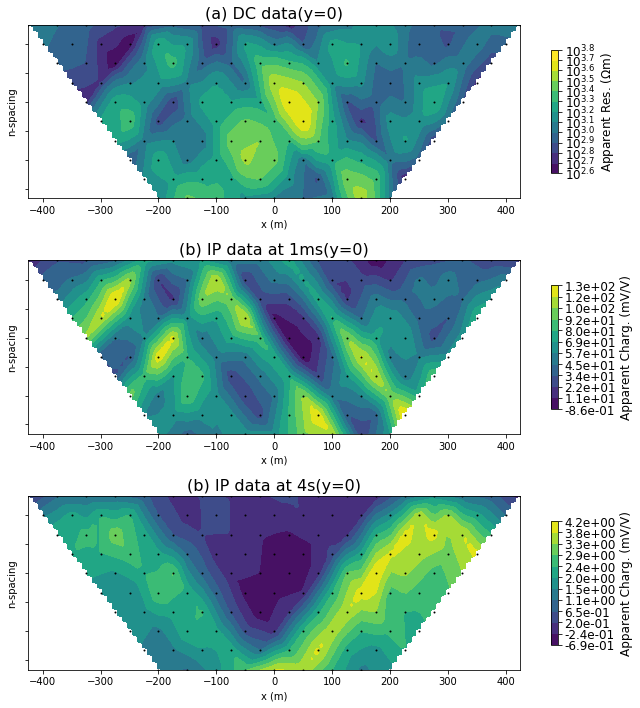

In [19]:
titles = ["(a) DC data", "(b) IP data at 1ms", "(b) IP data at 4s"]
fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
IO_2d.plotPseudoSection(ax=ax1, data=data_dc/IO_2d.G)
IO_2d.plotPseudoSection(
    data_type='apparent_chargeability', data=data_sip[:,0]*1e3, scale='linear',
    ax=ax2
)
IO_2d.plotPseudoSection(
    data_type='apparent_chargeability', data=data_sip[:,20]*1e3, scale='linear',
    ax=ax3
)
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(titles[i] + "(y=0)", fontsize = 16)
plt.tight_layout()
fig.savefig(fig_dir+"data", dpi=200)

### Show integrated IP data

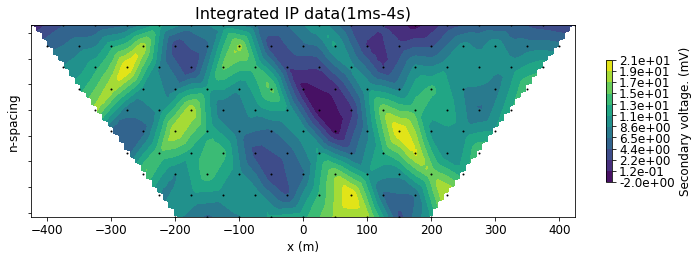

In [20]:
titles = ["Integrated IP data(1ms-4s)", "IP data at 1ms", "IP data at 4s"]
fig = plt.figure(figsize = (10, 10))
ax1 = plt.subplot(311)
out = IO_2d.plotPseudoSection(
    data_type='volt_ip', data=data_ip_int*1e3, scale='linear',
    ax=ax1, label='ms'
)
for i, ax in enumerate([ax1]):
    ax.set_title(titles[i], fontsize = 16)
plt.tight_layout()

### Show just IP data

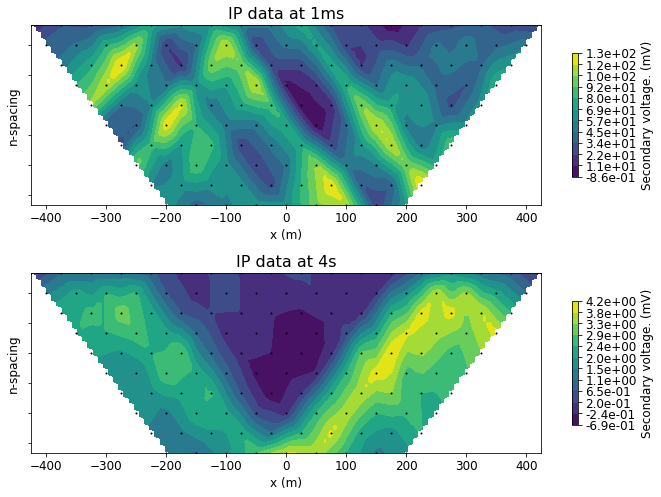

In [21]:
titles = ["IP data at 1ms", "IP data at 4s"]
fig = plt.figure(figsize = (10, 10))
ax2 = plt.subplot(311)
ax3 = plt.subplot(312)

IO_2d.plotPseudoSection(
    data_type='volt_ip', data=data_sip[:,0]*1e3, scale='linear',
    ax=ax2
)
IO_2d.plotPseudoSection(
    data_type='volt_ip', data=data_sip[:,20]*1e3, scale='linear',
    ax=ax3
)
for i, ax in enumerate([ax2, ax3]):
    ax.set_title(titles[i], fontsize = 16)
plt.tight_layout()

## Run DC inversion to obtain conductivity model

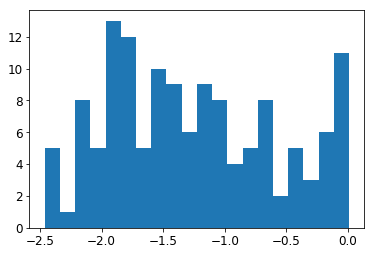

In [22]:
out = plt.hist(np.log10(abs(IO_2d.data_dc)), bins=20)

In [23]:
import numpy as np
from SimPEG import (Maps, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)


def run_inversion(
    m0, survey, actind, mesh,
    std, eps,
    maxIter=30, beta0_ratio=1e0,
    coolingFactor=5, coolingRate=2,
    upper=np.inf, lower=-np.inf,
    use_sensitivity_weight=True,
    alpha_s=1e-1,
    alpha_x=1.,
    alpha_y=1.,
    alpha_z=1.,
):
    """
    Run DC inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    regmap = Maps.IdentityMap(nP=int(actind.sum()))
    # Related to inversion
    if use_sensitivity_weight:
        reg = Regularization.Sparse(mesh, indActive=actind, mapping=regmap, cell_weights=mesh.vol)
        reg.alpha_s = alpha_s
        reg.alpha_x = alpha_x
        reg.alpha_y = alpha_y
        reg.alpha_z = alpha_z
    else:
        reg = Regularization.Sparse(mesh, indActive=actind, mapping=regmap, cell_weights=mesh.vol)
        reg.alpha_s = alpha_s
        reg.alpha_x = alpha_x
        reg.alpha_y = alpha_y
        reg.alpha_z = alpha_z

    opt = Optimization.ProjectedGNCG(maxIter=maxIter, upper=upper, lower=lower)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    # Need to have basice saving function
    update_Jacobi = Directives.UpdatePreconditioner()
    IRLS = Directives.Update_IRLS(
        maxIRLSiter=20, minGNiter=1,
        betaSearch=False, fix_Jmatrix=True
    )    
    if use_sensitivity_weight:
        updateSensW = Directives.UpdateSensitivityWeights()
        directiveList = [
            beta, betaest, IRLS, updateSensW
        ]
    else:
        directiveList = [
            beta, betaest, target
        ]
    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')

    # Run inversion
    mopt = inv.run(m0)
    return mopt, invProb.dpred

survey_2d.dobs = data_dc.copy()
m0_dc = np.ones(actind.sum())*np.log(1./1e3)
mopt_dc, pred_dc = run_inversion(
    m0_dc, survey_2d, actind, mesh_2d, 0.02, 10**-3, use_sensitivity_weight=False
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.75e-01  1.28e+04  0.00e+00  1.28e+04    4.62e+03      0              
   1  1.75e-01  1.53e+03  2.70e+03  2.00e+03    5.81e+02      0              
   2  3.50e-02  5.26e+02  4.40e+03  6.80e+02    1.58e+02      0   Skip BFGS  
   3  3.50e-02  2.42e+02  6.78e+03  4.80e+02    1.01e+02      0   Skip BFGS  
   4  7.01e-03  1.99e+02  6.92e+03  2.47e+02    9.95e+01      0              
   5  7.01e-03  1.35e+02  8.59e+03  1.95e+02    1.37e+02      0   Skip 

### Recovered resistivity

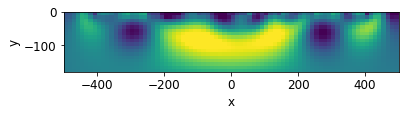

In [24]:
mesh_2d_core.plotImage(
    1./np.exp(mopt_dc[core_2d_inds]), pcolorOpts={'norm':matplotlib.colors.LogNorm()},
    clim=(300, 5000)
)
plt.gca().set_aspect(1)

### Comparison of observed and predicted

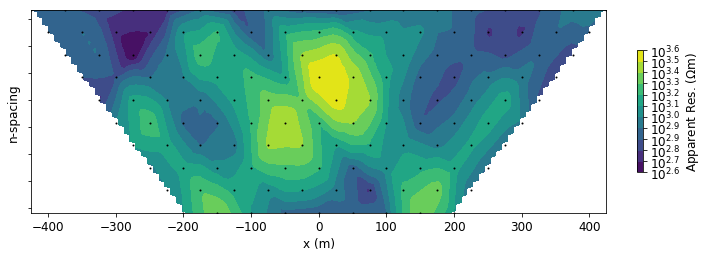

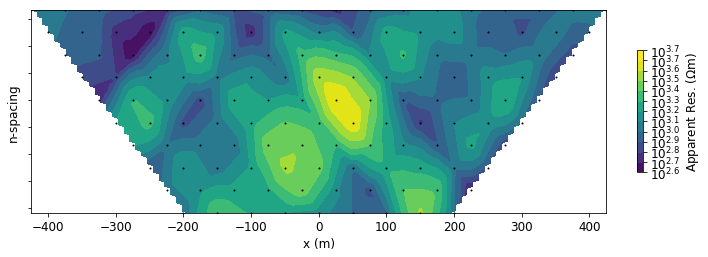

In [25]:
IO_2d.plotPseudoSection()
IO_2d.plotPseudoSection(data=pred_dc/IO_2d.G)

## Run conventional IP inversion

In [26]:
from SimPEG import IP
actMap_ip = Maps.InjectActiveCells(mesh_2d, actind, valInactive=0.)
survey_2d_ip = IP.from_dc_to_ip_survey(survey_2d)
problem_ip = IP.Problem2D_N(
    mesh_2d, sigma=sigmaMap*mopt_dc, etaMap=actMap_ip,
    storeJ=True,
    Solver=PardisoSolver
)
problem_ip.pair(survey_2d_ip)

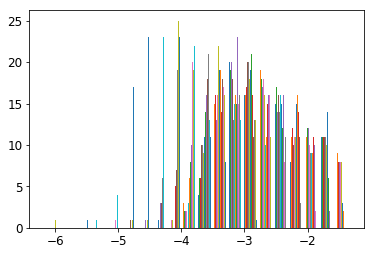

In [27]:
out = plt.hist(np.log10(abs(IO_2d.data_sip)), bins=20)

In [28]:
m0_ip = np.ones(actind.sum()) * 1e-4
eps = abs(data_dc.copy()) * 1e-3
eps += 1e-4
survey_2d_ip.dobs = data_ip_int.copy() * pred_dc 
mopt_ip, pred_ip = IP.run_inversion(
    m0_ip, survey_2d_ip, actind, mesh_2d, 0.02, eps,
    use_sensitivity_weight=False, maxIter=30, 
    lower=0.,
    alpha_s = 0.1
)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.05e+01  7.31e+02  0.00e+00  7.31e+02    1.18e+04      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.3247e+01
0 : |xc-x_last| = 2.3071e-01 <= tolX*(1+|x0|) = 1.0050e-01
0 : |proj(x-g)-x|    = 1.1831e+04 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.1831e+04 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      

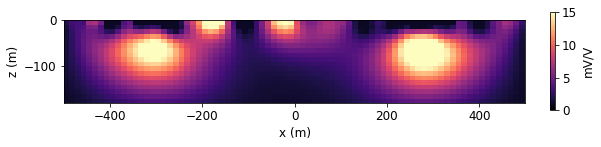

In [29]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1,1, figsize=(8*1.1, 7.5*1.1))
out = mesh_2d_core.plotImage(
    mopt_ip[core_2d_inds]*1e3 + 1., pcolorOpts={'cmap':'magma'}, ax=ax, 
    clim=(0, 15)
)
cb = plt.colorbar(out[0], fraction=0.01)
cb.set_label("mV/V")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
plt.gca().set_aspect(1)

## Separate inversion of all IP channels

One may stop here, but we would like to extract spectral information. 
So we successively invert multiple time channels of the IP data (1ms-4s), and obtain 
pseudo-chargeabilities at multiple times. 

In [30]:
times = output_simulation['times'].value
petas = np.empty((mesh_2d_core.nC, times.size), dtype=float, order='F')
pred_ips = np.empty(((survey_2d.nD, times.size)), dtype=float, order='F')
m0_ip = np.ones(actind.sum()) * 1e-4
for i_time in range(times.size):
    dobs_ip = data_sip[:,i_time]
    eps = abs(data_dc.copy()) * 1e-3
    eps += 1e-4
    survey_2d_ip.dobs = dobs_ip.copy() * pred_dc 
    mopt_ip, pred_ip = IP.run_inversion(
        m0_ip, survey_2d_ip, actind, mesh_2d, 0.02, eps,
        use_sensitivity_weight=False, maxIter=30, 
        lower=0.,
        alpha_s = 0.1
    )
    petas[:,i_time] = mopt_ip[core_2d_inds]

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.57e+01  1.38e+04  0.00e+00  1.38e+04    3.16e+04      0              
   1  1.57e+01  2.98e+02  1.74e+01  5.71e+02    2.69e+03      0              
   2  3.14e+00  1.55e+02  1.98e+01  2.17e+02    1.47e+03      0              
   3  3.14e+00  9.73e+01  2.34e+01  1.71e+02    1.09e+03      0   Skip BFGS  
   4  6.27e-01  8.12e+01  2.48e+01  9.68e+01    9.50e+02      0              
   5  6.27e

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.65e+01  1.24e+04  0.00e+00  1.24e+04    3.09e+04      0              
   1  1.65e+01  2.39e+02  1.44e+01  4.77e+02    2.78e+03      0              
   2  3.31e+00  1.25e+02  1.59e+01  1.78e+02    1.31e+03      0              
   3  3.31e+00  8.08e+01  1.85e+01  1.42e+02    1.11e+03      0   Skip BFGS  
   4  6.61e-01  6.99e+01  1.92e+01  8.26e+01    1.05e+03      0              
-----------

   0  2.07e+01  7.27e+03  0.00e+00  7.27e+03    2.76e+04      0              
   1  2.07e+01  1.66e+02  6.77e+00  3.06e+02    2.43e+03      0              
   2  4.13e+00  8.22e+01  7.75e+00  1.14e+02    8.58e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.2667e+02
0 : |xc-x_last| = 1.4769e-01 <= tolX*(1+|x0|) = 1.0050e-01
0 : |proj(x-g)-x|    = 8.5779e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 8.5779e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =      3
------------------------- DONE! -------------------------
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=======

model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.50e+01  3.16e+01  0.00e+00  3.16e+01    1.67e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.2642e+00
1 : |xc-x_last| = 6.2207e-02 <= tolX*(1+|x0|) = 1.0050e-01
0 : |proj(x-g)-x|    = 1.6742e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.6742e+03 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =      1
------------------------- DONE! -------------------------


### Plot recovered pseudo-chargeabilities

Pseudo-chargeabilities at 1ms and 4s are different in particular of the near surface chargeable materials (clay). 
They were imaged in 1ms, but disappeared in 4s. This is due to fast decaying nature (small $\tau$  and large $c$) of the clay compared to halo and mineralization. 

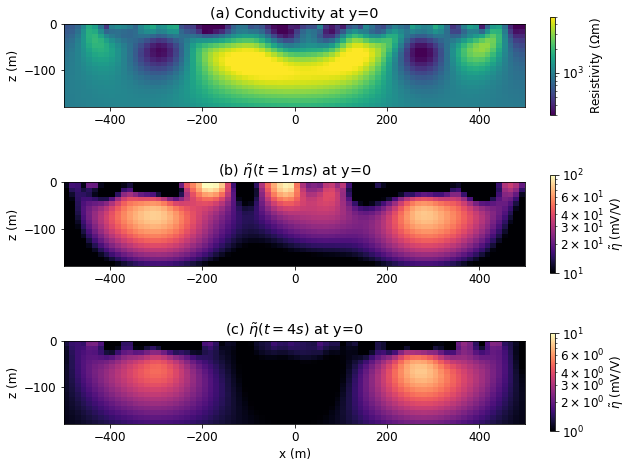

In [31]:
props = [1./np.exp(mopt_dc[core_2d_inds]), (petas[:,10]+1e-3)*1000, (petas[:,20]+1e-3)*1000]
cmaps = ['viridis', 'magma', 'magma']
labels = [
    "Resistivity ($\Omega$m)",
    "$\\tilde{\eta}$ (mV/V)",
    "$\\tilde{\eta}$ (mV/V)"
]
titles = [
            '(a) Conductivity',
            '(b) $\\tilde{\eta}(t=1ms)$',
            '(c) $\\tilde{\eta}(t=4s)$',
]
clims  = [(300, 5000.), (0.01*1000, 0.1*1000),(0.001*1000, 0.01*1000)]
fig, axs = plt.subplots(3,1, figsize=(8*1.1, 7.5*1.1))
for i, value in enumerate(props):
    vmin, vmax = value.min(), value.max()
    out = mesh_2d_core.plotImage(
        value, grid=False, clim=clims[i], pcolorOpts={'cmap':cmaps[i], 'norm':matplotlib.colors.LogNorm()}, 
        ax=axs[i]
    )
    axs[i].set_aspect("equal")
    cb = plt.colorbar(out[0], fraction=0.01, ax=axs[i])
    if i<3:
        axs[i].set_xlabel("")
    axs[i].set_title(titles[i]+" at y=0")
    cb.set_label(labels[i], fontsize = 12)
    axs[i].set_ylabel("z (m)")
axs[-1].set_xlabel("x (m)")
    
fig.savefig(fig_dir+"inversion_conventional_linear", dpi=200)    

## Extract SE parameters from the recovered pseudo-chargeabilities

To obtain quantitative SIP information from the recovered pseudo-chargeabilities, we set up an inverse problem. 
This inversion inverts pseudo-chargeabilities at all time channels to extract distributed SE parameters. 

In [32]:
def run_inversion(
    m0, survey, actind, mesh, wires,
    std, eps,
    maxIter=15, beta0_ratio=1e0,
    coolingFactor=2, coolingRate=2,
    maxIterLS=20, maxIterCG=10, LSshorten=0.5,
    eta_lower=1e-5, eta_upper=1,
    tau_lower=1e-6, tau_upper=10.,
    c_lower=1e-2, c_upper=1.,
    is_log_tau=True,
    is_log_c=True,
    is_log_eta=True,
    mref=None,
    alpha_s=1e-4,
    alpha_x=1e0,
    alpha_y=1e0,
    alpha_z=1e0,
):
    """
    Run Spectral Spectral IP inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    # Related to inversion

    # Set Upper and Lower bounds
    e = np.ones(actind.sum())

    if np.isscalar(eta_lower):
        eta_lower = e * eta_lower
    if np.isscalar(tau_lower):
        tau_lower = e * tau_lower
    if np.isscalar(c_lower):
        c_lower = e * c_lower

    if np.isscalar(eta_upper):
        eta_upper = e * eta_upper
    if np.isscalar(tau_upper):
        tau_upper = e * tau_upper
    if np.isscalar(c_upper):
        c_upper = e * c_upper

    if is_log_eta:
        eta_upper = np.log(eta_upper)
        eta_lower = np.log(eta_lower)

    if is_log_tau:
        tau_upper = np.log(tau_upper)
        tau_lower = np.log(tau_lower)

    if is_log_c:
        c_upper = np.log(c_upper)
        c_lower = np.log(c_lower)

    m_upper = np.r_[eta_upper, tau_upper, c_upper]
    m_lower = np.r_[eta_lower, tau_lower, c_lower]

    # Set up regularization
    reg_eta = Regularization.Sparse(
        mesh, mapping=wires.eta, indActive=actind
    )
    reg_tau = Regularization.Sparse(
        mesh, mapping=wires.tau, indActive=actind
    )
    reg_c = Regularization.Sparse(
        mesh, mapping=wires.c, indActive=actind
    )

    # Todo:

    reg_eta.alpha_s = alpha_s
    reg_tau.alpha_s = alpha_s
    reg_c.alpha_s = alpha_s

    reg_eta.alpha_x = alpha_x
    reg_tau.alpha_x = alpha_x
    reg_c.alpha_x = alpha_x

    reg_eta.alpha_y = alpha_y
    reg_tau.alpha_y = alpha_y
    reg_c.alpha_y = alpha_y

    reg_eta.alpha_z = alpha_z
    reg_tau.alpha_z = alpha_z
    reg_c.alpha_z = alpha_z

    reg = reg_eta + reg_tau + reg_c

    # Use Projected Gauss Newton scheme
    opt = Optimization.ProjectedGNCG(
        maxIter=maxIter, upper=m_upper, lower=m_lower,
        maxIterLS=maxIterLS, maxIterCG=maxIterCG, LSshorten=LSshorten
        )
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    invProb.beta=0.
    directiveList = [
            target
    ]

    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')

    # Run inversion
    mopt = inv.run(m0)
    return mopt, invProb.dpred


### Trial #1: $m=(\eta_{se}, log(\tau_{se}), c_{se})$

This case did not converge. 

In [34]:
from SimPEG import SIP
eta0 = np.ones(mesh_2d_core.nC)*0.01
tau0 = np.ones(mesh_2d_core.nC)*0.1
c0 = np.ones(mesh_2d_core.nC)*1.
actind_core = np.ones(mesh_2d_core.nC, dtype=bool)
eta_map, tau_map, c_map, wires =  SIP.spectral_ip_mappings(
    mesh_2d_core, indActive=actind_core, 
    is_log_eta=False,
    is_log_tau=True,
    is_log_c=False
)
# m0 = np.r_[np.log(eta0), np.log(tau0), np.log(c0)]
m0 = np.r_[(eta0), np.log(tau0), (c0)]
def run_sip(m0):
    survey_curvefit = SIP.SEMultiSurvey(times, mesh_2d_core.gridCC[actind_core,:], n_pulse=2, T=16.)
    survey_curvefit.dobs = petas.flatten()
    prob_curvefit = SIP.SEMultiInvProblem(
        mesh_2d_core, etaMap = eta_map, tauMap = tau_map, cMap=c_map,
        Solver=PardisoSolver
    )
    prob_curvefit.pair(survey_curvefit)
    # m0 = np.r_[(eta0), np.log(tau0), (c0)]
    eps = np.percentile(petas, 95, axis=0) * 0.05
    eps = eps.repeat(actind_core.sum())    
    mopt, pred = run_inversion(
        m0, survey_curvefit, actind_core, mesh_2d_core, wires, 0.05, eps, 
        is_log_eta=False, 
        is_log_tau=True, 
        is_log_c=False,     
        maxIter=20, 
        tau_upper=1e2,
        alpha_s=0.1,
        coolingFactor=2.
    )
    return mopt, pred, survey_curvefit.dobs, prob_curvefit
mopt_unbalanced, pred_unbalanced, dobs_unbalanced, prob_curvefit_unbalanced = run_sip(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  8.74e+05  0.00e+00  8.74e+05    2.65e+02      0              
   1  0.00e+00  2.07e+05  9.51e+00  2.07e+05    2.48e+02      0              
   2  0.00e+00  1.39e+05  1.91e+01  1.39e+05    2.42e+02      0   Skip BFGS  
   3  0.00e+00  1.30e+05  2.15e+01  1.30e+05    2.46e+02   

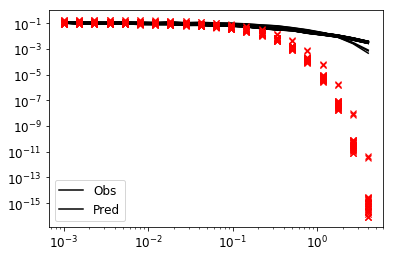

In [35]:
inds = petas[:,0]>0.1
temp_petas = petas[inds,:]
temp_pred = pred_unbalanced.reshape((mesh_2d_core.nC, times.size))[inds,:]
out = plt.loglog(times, temp_petas.T, 'k-')
out = plt.loglog(times, temp_pred.T, 'rx')
plt.legend(("Obs", "Pred"))

### Trial #2: $m=(log(\eta_{se}), log(\tau_{se}), log(c_{se}))$

This case converged after 6 iterations.

In [36]:
from SimPEG import SIP
eta0 = np.ones(mesh_2d_core.nC)*0.01
tau0 = np.ones(mesh_2d_core.nC)*0.1
c0 = np.ones(mesh_2d_core.nC)*1.
actind_core = np.ones(mesh_2d_core.nC, dtype=bool)
eta_map, tau_map, c_map, wires =  SIP.spectral_ip_mappings(
    mesh_2d_core, indActive=actind_core, 
    is_log_eta=True,
    is_log_tau=True,
    is_log_c=True
)
m0 = np.r_[np.log(eta0), np.log(tau0), np.log(c0)]
# m0 = np.r_[(eta0), np.log(tau0), (c0)]
def run_sip(m0):
    survey_curvefit = SIP.SEMultiSurvey(times, mesh_2d_core.gridCC[actind_core,:], n_pulse=2, T=16.)
    survey_curvefit.dobs = petas.flatten()
    prob_curvefit = SIP.SEMultiInvProblem(
        mesh_2d_core, etaMap = eta_map, tauMap = tau_map, cMap=c_map,
        Solver=PardisoSolver
    )
    prob_curvefit.pair(survey_curvefit)
    # m0 = np.r_[(eta0), np.log(tau0), (c0)]
    eps = np.percentile(petas, 95, axis=0) * 0.05
    eps = eps.repeat(actind_core.sum())    
    mopt, pred = run_inversion(
        m0, survey_curvefit, actind_core, mesh_2d_core, wires, 0.05, eps, 
        is_log_eta=True, 
        is_log_tau=True, 
        is_log_c=True,     
        maxIter=20, 
        tau_upper=1e2,
        alpha_s=0.1,
        coolingFactor=2.
    )
    return mopt, pred, survey_curvefit.dobs, prob_curvefit
mopt, pred, dobs, prob_curvefit = run_sip(m0)
eta_est_curvefit = np.exp(wires.eta * mopt)
tau_est_curvefit = np.exp(wires.tau * mopt)
c_est_curvefit = np.exp(wires.c * mopt)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  8.74e+05  0.00e+00  8.74e+05    3.27e+02      0              
   1  0.00e+00  4.72e+05  2.51e+04  4.72e+05    3.70e+02      1              
   2  0.00e+00  8.14e+04  3.73e+04  8.14e+04    3.95e+02      0              
   3  0.00e+00  2.59e+04  4.79e+04  2.59e+04    2.95e+02   

In [37]:
inds_eta = eta_est_curvefit > 0.08

In [38]:
np.sqrt(9.24e+04*2 / dobs.size)

2.4720661623652207

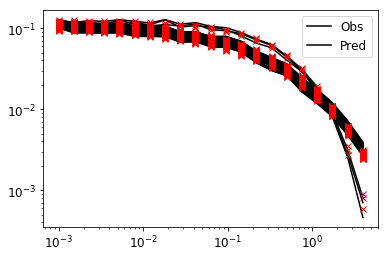

In [39]:
inds = petas[:,0]>0.1
temp_petas = petas[inds,:]
temp_pred = pred.reshape((mesh_2d_core.nC, times.size))[inds,:]
out = plt.loglog(times, temp_petas.T, 'k-')
out = plt.loglog(times, temp_pred.T, 'rx')
plt.legend(("Obs", "Pred"))

### Why Trial#1 showed poor convergence?
By analyzing the gradient of the data misifit function, $\phi_d$, we show why the 
logarithmic model showed better convergence. 

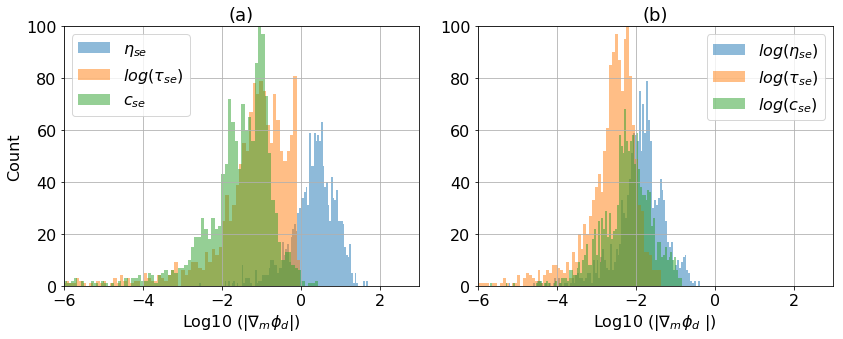

In [40]:
import matplotlib
matplotlib.rcParams['font.size'] =16
fig, ax = plt.subplots(1,2, figsize=(12, 5))
uncert = abs(dobs_unbalanced) * 0.05 + 0.0025
r = (pred_unbalanced - dobs) / uncert
jtvec = prob_curvefit_unbalanced.Jtvec(mopt_unbalanced, r)
value_med = []
for i in range(3):
    value = np.log10(abs(jtvec.reshape((mesh_2d_core.nC, 3), order="F")[:,i]))
    value_med.append(np.median(value))
    out = ax[0].hist(value, bins=100, alpha=0.5, color="C"+str(i))
ax[0].legend(("$\eta_{se}$", "$log(\\tau_{se}$)", "$c_{se}$"))    
# for i in range(3):
#     print (10**value_med[i])
#     ax[0].plot(np.ones(2)*value_med[i], np.r_[0, 25], color="C"+str(i), linestyle='--')
ax[0].set_xlabel("Log10 ($| \\nabla_m \phi_d |$)")
ax[0].set_ylabel("Count")
ax[0].grid(True)
r = (pred - dobs)/ uncert
jtvec = prob_curvefit.Jtvec(mopt, r)
value_med = []
for i in range(3):
    value = np.log10(abs(jtvec.reshape((mesh_2d_core.nC, 3), order="F")[:,i]))
    value_med.append(np.median(value))
    out = ax[1].hist(value, bins=100, alpha=0.5, color="C"+str(i))
ax[1].legend(("$log(\eta_{se})$", "$log(\\tau_{se}$)", "$log(c_{se})$"))    
# for i in range(3):
#     print (10**value_med[i])
#     ax[1].plot(np.ones(2)*value_med[i], np.r_[0, 25], color="C"+str(i), linestyle='--')
ax[1].set_xlabel("Log10 ($| \\nabla_m \phi_d \ |$)")
ax[1].grid(True)

ax[0].set_title("(a)", fontsize=18)
ax[1].set_title("(b)", fontsize=18)
ax[0].set_xlim(-6, 3)
ax[1].set_xlim(-6, 3)
ax[0].set_ylim(0, 100)
ax[1].set_ylim(0, 100)

plt.tight_layout()
fig.savefig(fig_dir+"gradient_histogram", dpi=200)

In [41]:
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

cmap = pl.cm.binary_r

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1., cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [42]:
dx = np.unique(mesh_2d_core.hx)
dz = np.unique(mesh_2d_core.hy)
X = mesh_2d_core.r(mesh_2d_core.gridCC[:,0], format='M')
Z = mesh_2d_core.r(mesh_2d_core.gridCC[:,1], format='M')
Value = mesh_2d_core.r(eta_est_curvefit, format='M')
# out = plt.contourf(X,Z, Value, cmap=my_cmap, levels=[1e-3, 0.08], ec='None')
# plt.colorbar(out)

### Show inversion results with $m=(log(\eta_{se}), log(\tau_{se}), log(c_{se}))$

Not bad, but distinguishing the mineralized zone from halo is hard.  

/Users/sgkang/anaconda3/lib/python3.7/site-packages/matplotlib/colorbar.py:600: UserWarning: set_ticks() must have been called.
  warnings.warn("set_ticks() must have been called.")


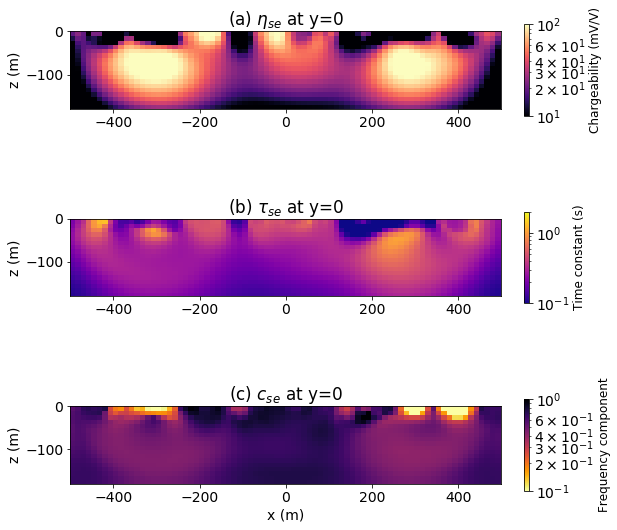

In [43]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
props = [eta_est_curvefit*1000, tau_est_curvefit, c_est_curvefit]
cmaps = ['magma', 'plasma', 'inferno_r']
labels = [
    "Chargeability (mV/V)",
    "Time constant (s)",
    "Frequency component"    
]
titles = [
            '(a) $\eta_{se}$',
            '(b) $\\tau_{se}$',
            '(c) $c_{se}$',    
]
clims  = [(0.01*1000, 0.1*1000), (0.1, 2.), (0.1, 1.)]
fig, axs = plt.subplots(3,1, figsize=(8*1.1, 10*3/4*1.1))
for i, value in enumerate(props):
    vmin, vmax = value.min(), value.max()
    out = mesh_2d_core.plotImage(
        value, grid=False, clim=clims[i], pcolorOpts={'cmap':cmaps[i], 'norm':matplotlib.colors.LogNorm()}, 
        ax=axs[i]
    )
#     axs[i].contourf(X,Z, Value, cmap=my_cmap, levels=[1e-3, 0.08])
#     axs[i].contour(X,Z, Value, colors='k', levels=[1e-3, 0.08], linewidths=1)    
    axs[i].set_aspect("equal")
    cb = plt.colorbar(out[0], fraction=0.01, ax=axs[i])
#     cb.set_ticks([vmin, vmax])
    cb.set_ticklabels(clims[i])
    if i<3:
        axs[i].set_xlabel("")
    axs[i].set_title(titles[i]+" at y=0")
    cb.set_label(labels[i], fontsize = 12)
    axs[i].set_title(titles[i]+" at y=0")
    axs[i].set_ylabel("z (m)")
axs[-1].set_xlabel("x (m)")
plt.tight_layout()    
fig.savefig(fig_dir+"inversion_conventional", dpi=200)    

## Run our SIP inversion

Now we simultaneously invert all IP time channels together to reconver distributed SE parameters. 

In [44]:
def run_inversion(
    m0, survey, actind, mesh, wires,
    std, eps,
    maxIter=15, beta0_ratio=1e0,
    coolingFactor=2, coolingRate=2,
    maxIterLS=20, maxIterCG=10, LSshorten=0.5,
    eta_lower=1e-5, eta_upper=1,
    tau_lower=1e-6, tau_upper=10.,
    c_lower=1e-2, c_upper=1.,
    is_log_tau=True,
    is_log_c=True,
    is_log_eta=True,
    mref=None,
    alpha_s=1e-4,
    alpha_x=1e0,
    alpha_y=1e0,
    alpha_z=1e0,
):
    """
    Run Spectral Spectral IP inversion
    """
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    uncert = abs(survey.dobs) * std + eps
    dmisfit.W = 1./uncert
    # Map for a regularization
    # Related to inversion

    # Set Upper and Lower bounds
    e = np.ones(actind.sum())

    if np.isscalar(eta_lower):
        eta_lower = e * eta_lower
    if np.isscalar(tau_lower):
        tau_lower = e * tau_lower
    if np.isscalar(c_lower):
        c_lower = e * c_lower

    if np.isscalar(eta_upper):
        eta_upper = e * eta_upper
    if np.isscalar(tau_upper):
        tau_upper = e * tau_upper
    if np.isscalar(c_upper):
        c_upper = e * c_upper

    if is_log_eta:
        eta_upper = np.log(eta_upper)
        eta_lower = np.log(eta_lower)

    if is_log_tau:
        tau_upper = np.log(tau_upper)
        tau_lower = np.log(tau_lower)

    if is_log_c:
        c_upper = np.log(c_upper)
        c_lower = np.log(c_lower)

    m_upper = np.r_[eta_upper, tau_upper, c_upper]
    m_lower = np.r_[eta_lower, tau_lower, c_lower]

    # Set up regularization
    reg_eta = Regularization.Sparse(
        mesh, mapping=wires.eta, indActive=actind, cell_weights=mesh.vol
    )
    reg_tau = Regularization.Sparse(
        mesh, mapping=wires.tau, indActive=actind, cell_weights=mesh.vol
    )
    reg_c = Regularization.Sparse(
        mesh, mapping=wires.c, indActive=actind, cell_weights=mesh.vol
    )
    reg_eta.norms = np.c_[0, 2, 2, 2]
    reg_tau.norms = np.c_[0, 2, 2, 2]
    reg_c.norms = np.c_[0, 2, 2, 2]    
    # Todo:

    reg_eta.alpha_s = alpha_s
    reg_tau.alpha_s = alpha_s
    reg_c.alpha_s = alpha_s

    reg_eta.alpha_x = alpha_x
    reg_tau.alpha_x = alpha_x
    reg_c.alpha_x = alpha_x

    reg_eta.alpha_y = alpha_y
    reg_tau.alpha_y = alpha_y
    reg_c.alpha_y = alpha_y

    reg_eta.alpha_z = alpha_z
    reg_tau.alpha_z = alpha_z
    reg_c.alpha_z = alpha_z
    
    reg = reg_eta + reg_tau + reg_c

    # Use Projected Gauss Newton scheme
    opt = Optimization.ProjectedGNCG(
        maxIter=maxIter, upper=m_upper, lower=m_lower,
        maxIterLS=maxIterLS, maxIterCG=maxIterCG, LSshorten=LSshorten
        )
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    beta = Directives.BetaSchedule(
        coolingFactor=coolingFactor, coolingRate=coolingRate
    )
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
    target = Directives.TargetMisfit()
    IRLS = Directives.Update_IRLS(betaSearch=False)
    IRLS.chifact_start = 1.
    directiveList = [
            beta, betaest, target
    ]

    inv = Inversion.BaseInversion(
        invProb, directiveList=directiveList
        )
    opt.LSshorten = 0.5
    opt.remember('xc')
    # Run inversion
    mopt = inv.run(m0)
    return mopt, invProb.dpred

In [45]:
eta_map, tau_map, c_map, wires =  SIP.spectral_ip_mappings(
    mesh_2d, indActive=actind, 
    is_log_eta = True,
    is_log_tau = True,
    is_log_c = True,    
)

problem = SIP.Problem2D_N(
    mesh_2d, sigma=sigmaMap*mopt_dc, etaMap=eta_map, tauMap=tau_map, cMap=c_map,
    storeJ=True,
    Solver=PardisoSolver
)
survey_2d_sip = SIP.from_dc_to_sip_survey(survey_2d, times)
survey_2d_sip.dobs = Utils.mkvc(data_sip)
survey_2d_sip.unpair()
survey_2d_sip.n_pulse = 2
survey_2d_sip.T = 16.
problem.pair(survey_2d_sip)
problem.set_dc_data(data_dc, dc_survey=survey_2d)

eta0 = np.zeros(actind.sum()) + 1e-2
tau0 = np.ones(actind.sum()) * 0.1
c0 = np.ones(actind.sum()) * 1.

m0 = np.r_[np.log(eta0[actind]), np.log(tau0[actind]), np.log(c0[actind])]
# eps = Utils.mkvc(abs(np.repeat(survey_2d.dobs.reshape([-1,1]), times.size, axis=1)) * 1e-3)
eps = 10**-3.
std = 0.05

mopt, pred = run_inversion(
    m0, survey_2d_sip, actind, mesh_2d, wires, std, eps, 
    is_log_eta=True, 
    is_log_tau=True, 
    is_log_c=True,     
    maxIter=30, 
    tau_upper=100.,
    alpha_s=0.1
)
eta_est = np.exp(wires.eta * mopt)
tau_est = np.exp(wires.tau * mopt)
c_est = np.exp(wires.c * mopt)


You did not put Active indices
So, set actMap = IdentityMap(mesh)
SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.65e-02  1.50e+05  0.00e+00  1.50e+05    3.10e+02      0              
   1  2.65e-02  4.40e+04  1.83e+04  4.45e+04    2.67e+02      2              
   2  1.32e-02  1.96e+04  4.04e+04  2.01e+04    4.45e+02      0        

In [46]:
inds_eta_2d = eta_est[core_2d_inds] > 0.08

In [47]:
X = mesh_2d_core.r(mesh_2d_core.gridCC[:,0], format='M')
Z = mesh_2d_core.r(mesh_2d_core.gridCC[:,1], format='M')
Value = mesh_2d_core.r(eta_est[core_2d_inds], format='M')
# out = plt.contourf(X,Z, Value, cmap=my_cmap, levels=[1e-3, 0.08], ec='None')
# plt.colorbar(out)

### Show recovered $\eta_{se}$, $\tau_{se}$, $c_{se}$
Now we are distinguishing the mineralized zone having large $\tau_{se}$!

Text(0.5, 0, 'x (m)')

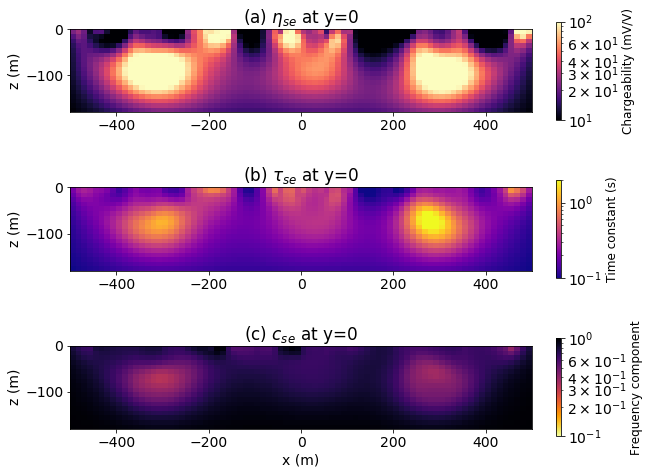

In [48]:
props = [eta_est[core_2d_inds]*1000, tau_est[core_2d_inds], c_est[core_2d_inds]]
cmaps = ['magma', 'plasma', 'inferno_r']
labels = [
    "Chargeability (mV/V)",
    "Time constant (s)",
    "Frequency component"    
]
titles = [
            '(a) $\eta_{se}$',
            '(b) $\\tau_{se}$',
            '(c) $c_{se}$',    
]
clims  = [(0.01*1000, 0.1*1000), (0.1, 2.), (0.1, 1.)]
# fig, axs = plt.subplots(3,1, figsize=(8*1.1, 10*3/4*1.1))
fig, axs = plt.subplots(3,1, figsize=(8*1.1, 7.5*1.1))
for i, value in enumerate(props):
    vmin, vmax = value.min(), value.max()
    out = mesh_2d_core.plotImage(
        value, grid=False, clim=clims[i], pcolorOpts={'cmap':cmaps[i], 'norm':matplotlib.colors.LogNorm()}, 
        ax=axs[i]
    )
#     axs[i].contourf(X,Z, Value, cmap=my_cmap, levels=[1e-3, 0.08])
#     axs[i].contour(X,Z, Value, colors='k', levels=[1e-3, 0.08], linewidths=1)

    axs[i].set_aspect("equal")
    cb = plt.colorbar(out[0], fraction=0.01, ax=axs[i])
#     cb.set_ticks([vmin, vmax])
    cb.set_ticklabels(clims[i])
    if i<3:
        axs[i].set_xlabel("")
    axs[i].set_title(titles[i]+" at y=0")
    cb.set_label(labels[i], fontsize = 12)
    axs[i].set_ylabel("z (m)")
axs[-1].set_xlabel("x (m)")    
# plt.tight_layout()
# fig.savefig(fig_dir+"inversion_sip_2d", dpi=200)        

Text(0.5, 0, 'x (m)')

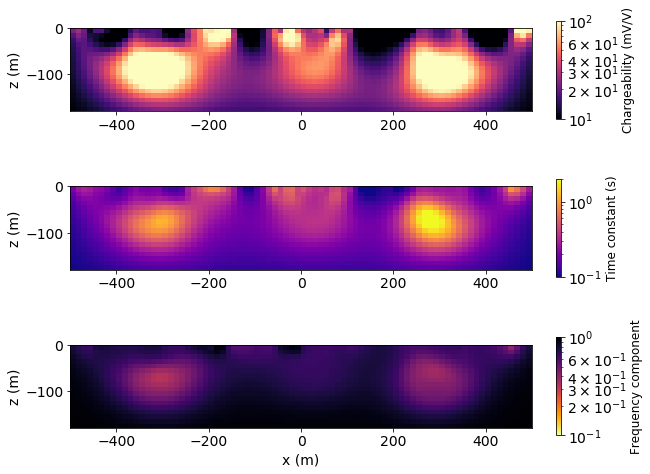

In [49]:
props = [eta_est[core_2d_inds]*1000, tau_est[core_2d_inds], c_est[core_2d_inds]]
cmaps = ['magma', 'plasma', 'inferno_r']
labels = [
    "Chargeability (mV/V)",
    "Time constant (s)",
    "Frequency component"    
]
titles = [
            '(a) $\eta_{se}$',
            '(b) $\\tau_{se}$',
            '(c) $c_{se}$',    
]
clims  = [(0.01*1000, 0.1*1000), (0.1, 2.), (0.1, 1.)]
# fig, axs = plt.subplots(3,1, figsize=(8*1.1, 10*3/4*1.1))
fig, axs = plt.subplots(3,1, figsize=(8*1.1, 7.5*1.1))
for i, value in enumerate(props):
    vmin, vmax = value.min(), value.max()
    out = mesh_2d_core.plotImage(
        value, grid=False, clim=clims[i], pcolorOpts={'cmap':cmaps[i], 'norm':matplotlib.colors.LogNorm()}, 
        ax=axs[i]
    )
#     axs[i].contourf(X,Z, Value, cmap=my_cmap, levels=[1e-3, 0.08])
#     axs[i].contour(X,Z, Value, colors='k', levels=[1e-3, 0.08], linewidths=1)

    axs[i].set_aspect("equal")
    cb = plt.colorbar(out[0], fraction=0.01, ax=axs[i])
#     cb.set_ticks([vmin, vmax])
    cb.set_ticklabels(clims[i])
    if i<3:
        axs[i].set_xlabel("")
#     axs[i].set_title(titles[i]+" at y=0")
    cb.set_label(labels[i], fontsize = 12)
    axs[i].set_ylabel("z (m)")
axs[-1].set_xlabel("x (m)")    
# plt.tight_layout()
# fig.savefig(fig_dir+"inversion_sip_2d", dpi=200)        

### Compare cross plot of  $\tau_{se}$ and $c_{se}$ 

/Users/sgkang/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


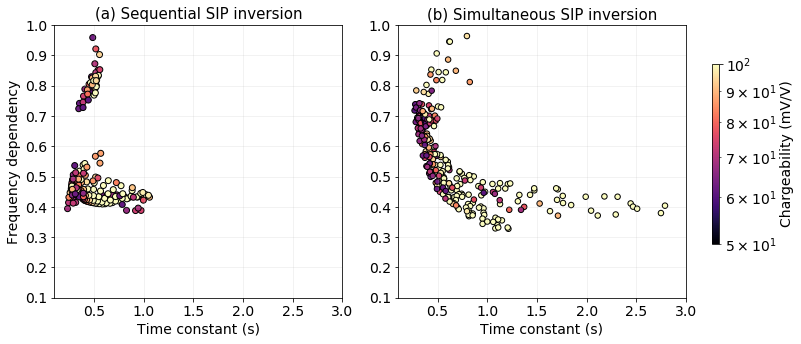

In [50]:
import matplotlib.gridspec as gs
fig = plt.figure(figsize=(10,5))
# gs = gs.GridSpec(1, 10)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
inds = eta_est_curvefit > 0.06
out = ax1.scatter(
    tau_est_curvefit[inds], c_est_curvefit[inds], c=eta_est_curvefit[inds]*1e3, cmap="magma",
    norm=colors.LogNorm(), vmin=0.05*1e3, vmax=0.1*1e3, edgecolor='black',
)

ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.grid(which='both', alpha=0.2)
ax1.set_xlabel("Time constant (s)")
ax1.set_ylabel("Frequency dependency")
inds = eta_est > 0.06
out = ax2.scatter(
    tau_est[inds], c_est[inds], c=eta_est[inds]*1e3,
    norm=colors.LogNorm(), vmin=0.05*1e3, vmax=0.1*1e3, s=30, cmap="magma",
    edgecolor='black',
)
cbaxes = fig.add_axes([1, 0.3, 0.01, 0.5]) 
cb = plt.colorbar(out, ax=ax2, cax = cbaxes) 
cb.set_label("Chargeability (mV/V)")

ax2.set_xlabel("Time constant (s)")
# ax2.set_ylabel("Frequency dependency")
ax1.set_title("(a) Sequential SIP inversion", fontsize=15)     
ax2.set_title("(b) Simultaneous SIP inversion", fontsize=15)     
for ax in [ax1, ax2]:
    ax.set_xlim(0.1, 3)
    ax.set_ylim(0.1, 1.)
    ax.set_xscale("linear")
    ax.set_yscale("linear")
    ax.grid(which="both", alpha=0.2)
plt.tight_layout()
# fig.savefig(fig_dir+"inversion_sip_2d_scatter", dpi=200)